#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/opt/anaconda3/envs/csma3/bin/python


# Install dependencies:

In [1]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [2]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [3]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [4]:
# Set pandas print options
This will improve readability of printed pandas dataframe.


SyntaxError: invalid syntax (<ipython-input-4-804d46c41beb>, line 2)

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [6]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [7]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [8]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [9]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.5307269
n_clusters: 102 silhouette_avg: 0.28006536
n_clusters: 202 silhouette_avg: 0.2542685


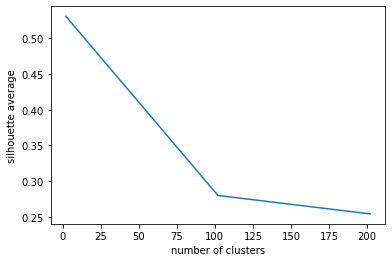

In [11]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=300 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [12]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 89     1
97     1
50     1
73     1
69     1
90     1
13     1
26     1
15     1
83     1
34     1
31     1
20     1
18     1
22     1
28     2
5      2
94     2
8      2
93     2
79     2
91     2
30     2
17     2
64     2
86     2
82     2
12     2
88     2
99     2
98     2
32     2
70     2
78     2
44     2
56     2
36     2
57     2
38     2
52     2
75     2
51     2
43     2
74     2
95     3
39     3
59     3
2      3
3      3
53     3
76     3
77     3
48     3
47     3
21     3
45     3
37     3
85     3
46     3
84     3
10     4
71     4
96     4
0      4
60     5
49     5
65     5
58     5
81     5
80     5
54     5
35     5
29     5
63     5
55     5
25     6
19     6
42     6
27     6
67     6
68     6
66     6
7      6
23     6
92     6
1      7
41     7
24     7
62     7
72     8
40     8
33     8
61     9
6      9
9     10
87    10
11    11
16    12
14    12
4     13
Name: label_kmedoids, dtype: int64


In [13]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [14]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\Users\Julius\anaconda3\envs\pythonEnv\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

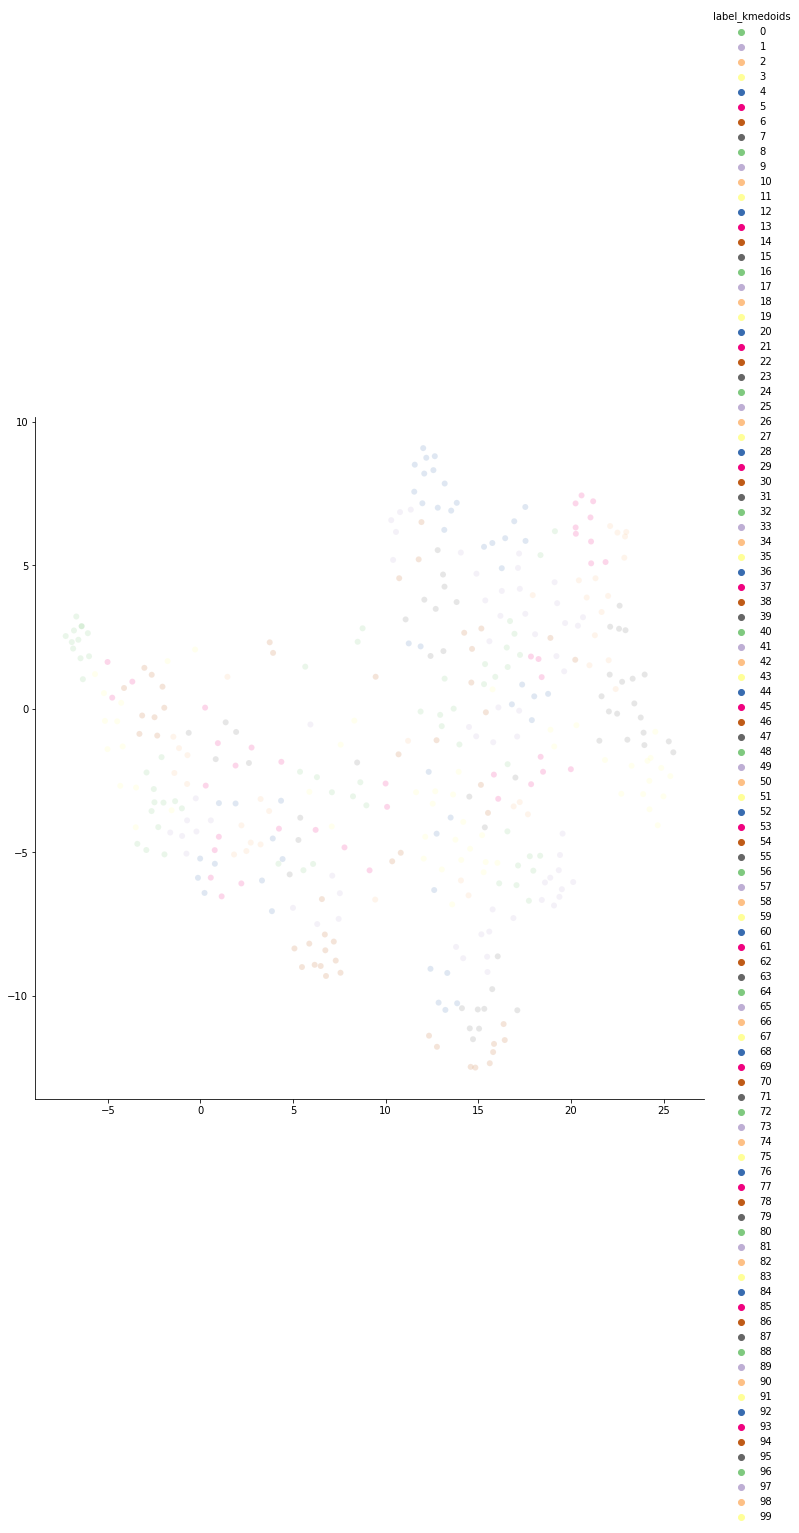

In [15]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

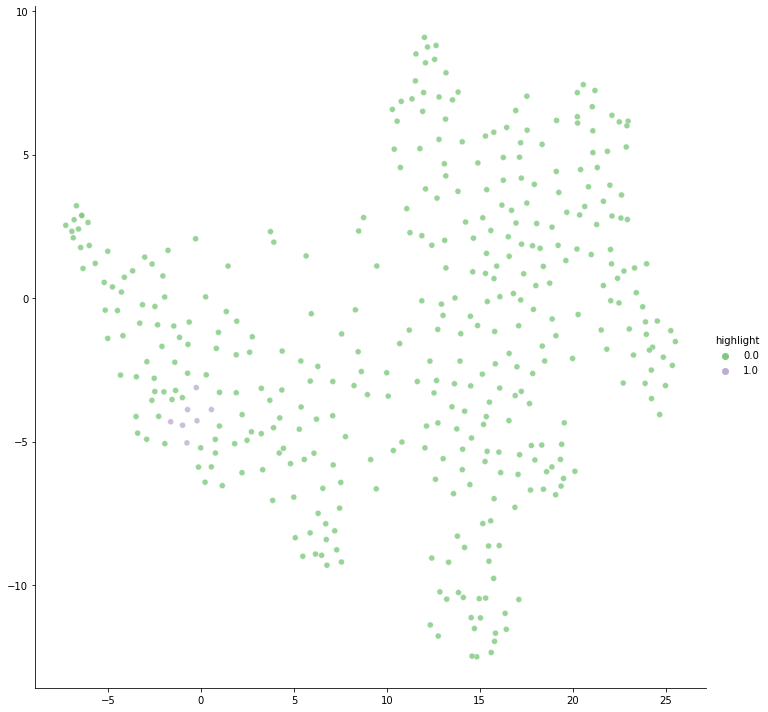

In [19]:
## Choose a cluster to higlight:
cluster_num = 1

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [17]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
160,2019-08-11 21:45:06,Gentile Gentleman,And this is how ben slowly slips you into believing in the climate catastrophe that will further push the middle class into the lower class and consolidate power under the guise of crisis prevention. Those who will trade freedom for safety deserve neither.,0,And this is how ben slowly slips you into believing in the climate catastrophe\nthat will further push the middle class into the lower class and consolidate\npower under the guise of crisis prevention. Those who will trade freedom for\nsafety deserve neither.\n\n,-1.0,0,5.960464e-08,0.0
244,2019-08-11 19:40:46,uploadJ,You're not making an awful lot of sense .. Just sayin.,1,You're not making an awful lot of sense .. Just sayin.\n\n,-1.0,1,0.000000e+00,0.0
320,2019-08-11 20:18:20,jmcsquared,"@Sam Norris The climate is changing, specifically due to the rapidly rising rate of global temperature increase, and it's due mainly to our greenhouse gas emissions. What that has to do with socialism and ""globalism"" I might never know. Also, our models have been accurate, they've successfully reproduced temperatures since 1900 globally, on land, in the air, and in the ocean. But the hyperbole and extreme rhetoric has been unwavering, which is a distraction from the actual dangers of global warming (which has nothing to do with Florida being underwater in three years, whoever made that up).",1,"@ The climate is changing, specifically due to the rapidly rising\nrate of global temperature increase, and it's due mainly to our greenhouse gas\nemissions. What that has to do with socialism and ""globalism"" I might never\nknow. Also, our models have been accurate, they've successfully reproduced\ntemperatures since 1900 globally, on land, in the air, and in the ocean. But\nthe hyperbole and extreme rhetoric has been unwavering, which is a distraction\nfrom the actual dangers of global warming (which has nothing to do with\nFlorida being underwater in three years, whoever made that up).\n\n",-1.0,2,0.000000e+00,0.0
127,2019-08-12 00:32:56,Skeeter,What about the vast majority of climatologists that disagree with him? Why side with the minority of the scientific community that you agree with rather than what the vast majority of scientists agree with?,1,What about the vast majority of climatologists that disagree with him? Why\nside with the minority of the scientific community that you agree with rather\nthan what the vast majority of scientists agree with?\n\n,-1.0,3,0.000000e+00,0.0
370,2019-08-11 19:52:59,Han,"How does disengagement from China solve anything? Let's say tomorrow we cut off all trade from China, these manufacturing capacities move to Vietnam, or Indonesia, wouldn't emission just increase in these countries?",1,"How does disengagement from China solve anything? Let's say tomorrow we cut\noff all trade from China, these manufacturing capacities move to Vietnam, or\nIndonesia, wouldn't emission just increase in these countries?\n\n",-1.0,4,0.000000e+00,0.0
5,2019-08-16 17:06:58,TorontoLarrivee,It&#39;s fun seeing a careful and temperate voice like Safron Foer engage with a gish galloping jackass like Shapiro.,0,It's fun seeing a careful and temperate voice like Safron Foer engage with a\ngish galloping jackass like Shapiro.\n\n,-1.0,5,0.000000e+00,0.0
46,2019-08-12 06:55:27,proven22x,That guy was meh,0,That guy was meh\n\n,-1.0,6,5.960464e-08,1.0
156,2019-08-11 21:46:23,rutger houtdijk,"His analogy would be correct if doctors were telling him for 30 years he had cancer and would die in a year without chemo, while at the same time those doctors were being paid to prescribe chemo.",0,"His analogy would be correct if doctors were telling him for 30 years he had\ncancer and would die in a year without chemo, while at the same time those\ndoctors were being paid to prescribe chemo.\n\n",-1.0,7,1.788139e-07,0.0
280,2019-08-11 18:29:33,oskaveli

In [18]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  4 mean distance from center:  0.0016614794731140137 Proportion of replies: 25.0
1 number of samples:  7 mean distance from center:  0.0014517988347506616 Proportion of replies: 100.0
2 number of samples:  3 mean distance from center:  0.0008344650268554688 Proportion of replies: 66.66666666666667
3 number of samples:  3 mean distance from center:  0.001237789820152102 Proportion of replies: 66.66666666666667
4 number of samples:  13 mean distance from center:  0.0007812793228367809 Proportion of replies: 92.3076923076923
5 number of samples:  2 mean distance from center:  0.000998377799987793 Proportion of replies: 50.0
6 number of samples:  9 mean distance from center:  0.0010940763786493335 Proportion of replies: 33.333333333333336
7 number of samples:  6 mean distance from center:  0.00031689803563494934 Proportion of replies: 16.666666666666668
8 number of samples:  2 mean distance from center:  0.00047385692596435547 Proportion of replies: 0.0
9 number of sam

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [25]:
# Choose a cluster to print
cluster_number =   4
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 13
Average Distance from cluster center: 7.812793e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
370,2019-08-11 19:52:59,Han,"How does disengagement from China solve anything? Let's say tomorrow we cut off all trade from China, these manufacturing capacities move to Vietnam, or Indonesia, wouldn't emission just increase in these countries?",1,"How does disengagement from China solve anything? Let's say tomorrow we cut\noff all trade from China, these manufacturing capacities move to Vietnam, or\nIndonesia, wouldn't emission just increase in these countries?\n\n",-1,4,0.000000,0.0
98,2019-08-12 02:39:50,Chaos is a ladder,And China will sell it's products elsewhere as they have already began doing. Why not set up a trade agreement that forces them to become more environmentally friendly? Would that be a better solution than just stopping trade?,1,And China will sell it's products elsewhere as they have already began doing.\nWhy not set up a trade agreement that forces them to become more\nenvironmentally friendly? Would that be a better solution than just stopping\ntrade?\n\n,-1,4,0.000002,0.0
95,2019-08-12 03:28:01,LiveWell6,@Chaos is a ladder Agreed. But tariffs and disengagement is probably a lower risk (to the safety of the American people) route to get to the same goal.,1,@ Agreed. But tariffs and disengagement is probably a lower\nrisk (to the safety of the American people) route to get to the same goal.\n\n,-1,4,0.000005,0.0
94,2019-08-12 03:43:32,Chaos is a ladder,@LiveWell6 yeah but now they are just expanding their trade with other countries and the USA is doing the opposite which gives use less influence in those areas as time goes on. So in the short term it hurts China but in the long term it helps them and increase their investment in other countries which gets them allies down the road. When we don't have those countries as our allies it's harder for use to get things we want from these same countries and weakens our global status.,1,@ yeah but now they are just expanding their trade with other\ncountries and the USA is doing the opposite which gives use less influence in\nthose areas as time goes on. So in the short term it hurts China but in the\nlong term it helps them and increase their investment in other countries which\ngets them allies down the road. When we don't have those countries as our\nallies it's harder for use to get things we want from these same countries and\nweakens our global status.\n\n,-1,4,0.000006,0.0
110,2019-08-12 03:13:53,simplesimonme2,@Skeeter which action can you point to? I hope not the leaving the Paris accords. We've reduced our emissions since leaving the accords more than any country that stayed in the accords,1,@ which action can you point to? I hope not the leaving the Paris\naccords. We've reduced our emissions since leaving the accords more than any\ncountry that stayed in the accords\n\n,-1,4,0.000006,0.0
96,2019-08-12 03:12:25,Chaos is a ladder,@LiveWell6 but we do have a way to enforce our trade agreements. We have the largest military in the world. We can make them bend over if we want to. We just haven't.,1,@ but we do have a way to enforce our trade agreements. We have the\nlargest military in the world. We can make them bend over if we want to. We\njust haven't.\n\n,-1,4,0.000006,0.0
355,2019-08-12 03:31:17,Nathan,@Foxintoxx They would pollute less because their production would decrease due to a smaller export market.,1,@ They would pollute less because their production would decrease due\nto a smaller export market.\n\n,-1,4,0.000007,0.0
360,2019-08-11 21:42:54,Han,"@Christopher Olsen You are right to some extent. Bigger countries have bigger responsibilities. However, the U.S. is still the #2 emitter in the world. That's more emission than EU-28 combined, and that's many times the number of countries than the U.S.!! Also, sticking to absolute emission by country is also problematic, as China can dissolve into many smaller countries to avoid responsibilities. E

In [26]:
# Choose a cluster to print
cluster_number =   87
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 10
Average Distance from cluster center: 1.0347367e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
74,2019-08-13 00:21:29,Alex G,"@dkosmari Im not sure what you mean by ""predicting temperatures"". There are predictions about temperature change. Like do you mean short term, or long term predictions? there are many accurate long-term predictions and forecasts about temperature and climate. If you are referring to short-term, one-day temperature predictions, then no, we cannot predict that. But thats the WEATHER, not the overall CLIMATE. I think you may be confusing the two. Another thing you mentioned was ""effective course of action"". There IS an effective course of action; reduce CO2 and greenhouse gas emissions. That would help preserve the stability of our climates. This is the course of action that would stop man's influence on climate change, but it would have terrible effects on the economy and progress. For this reason I agree with you 100% that innovation and technology is our best bet. And no. Im not saying that there was more man made climate change back then. What im saying is that climate change ALSO existed back then. Ever since the Industrial revolution, the climate has been increasingly volatile and unpredictable. But now, instead of a heatwave once every 10, or 15 years; there is a heatwave every 2 - 3 years. Heres another question for you. How do you explain all of the floodings and cat 5 hurricanes that have been happening? It seems like every couple years we have a ""Once in 100 year"" flood. To say that humans havent had an influence on this is ignorant. We cannot say forsure that climate change is due solely to human intervention, but there is a positive correlation between emissions and the increase in average global temperature. Finally, very few politicians are calling for those prescriptions. The ones that are suggesting these things, or ""Green New Deals"", are just imbeciles. But we should without a doubt consider some of these things - in a non-extreme proportion.",1,"@ Im not sure what you mean by ""predicting temperatures"". There are\npredictions about temperature change. Like do you mean short term, or long\nterm predictions? there are many accurate long-term predictions and forecasts\nabout temperature and climate. If you are referring to short-term, one-day\ntemperature predictions, then no, we cannot predict that. But thats the\nWEATHER, not the overall CLIMATE. I think you may be confusing the two.\nAnother thing you mentioned was ""effective course of action"". There IS an\neffective course of action; reduce CO2 and greenhouse gas emissions. That\nwould help preserve the stability of our climates. This is the course of\naction that would stop man's influence on climate change, but it would have\nterrible effects on the economy and progress. For this reason I agree with you\n100% that innovation and technology is our best bet. And no. Im not saying\nthat there was more man made climate change back then. What im saying is that\nclimate change ALSO existed back then. Ever since the Industrial revolution,\nthe climate has been increasingly volatile and unpredictable. But now, instead\nof a heatwave once every 10, or 15 years; there is a heatwave every 2 - 3\nyears. Heres another question for you. How do you explain all of the floodings\nand cat 5 hurricanes that have been happening? It seems like every couple\nyears we have a ""Once in 100 year"" flood. To say that humans havent had an\ninfluence on this is ignorant. We cannot say forsure that climate change is\ndue solely to human intervention, but there is a positive correlation between\nemissions and the increase in average global temperature. Finally, very few\npoliticians are calling for those prescriptions. The ones that are suggesting\nthese things, or ""Green New Deals"", are just imbeciles. But we should without\na doubt consider some of these things - in a non-extreme proportion.\n\n",-1,87,1.788139e-07,0.0
216,2019-08-12 03:27:23,

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [22]:
#which cluster would you like to assign labels to?
cluster_number = 18
#your label
label_manual = 'music'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [23]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
138,2019-08-11 22:26:59,Bryan Guevara,Debate Philosophy Tube,0,Debate Philosophy Tube\n\n,music,18,0.0,0.0
